# Dataset Creation & Modeling

In [ ]:
import pandas as pd


mida = pd.read_csv('resources/MID-5-Data-and-Supporting-Materials/MIDA 5.0.csv')
midb = pd.read_csv('resources/MID-5-Data-and-Supporting-Materials/MIDB 5.0.csv')
midi = pd.read_csv('resources/MID-5-Data-and-Supporting-Materials/MIDI 5.0.csv')
midip = pd.read_csv('resources/MID-5-Data-and-Supporting-Materials/MIDIP 5.0.csv')

mida['use_force_or_war'] = (mida['hostlev'] >= 4).astype(int)


mida_filtered = mida[mida['dispnum'].isin(midi['dispnum'].unique())]

participant_features = []

for (dispnum, ccode), group in midip.groupby(['dispnum', 'ccode']):
    group = group.sort_values(by=['styear', 'stmon', 'stday'])

    num_incidents = group['incidnum'].nunique()
    if num_incidents <= 2:
        early_group = group
    else:
        half = num_incidents // 2
        early_incid_nums = group['incidnum'].unique()[:half]
        early_group = group[group['incidnum'].isin(early_incid_nums)]

    row = {
        'dispnum': dispnum,
        'ccode': ccode,
        'participant_incident_count': len(early_group),
        'participant_threat_count': (early_group['action'] < 3).sum(),
        'participant_force_count': (early_group['action'] >= 9).sum(),
        'participant_max_action': early_group['action'].max(),
        'participant_mean_hostlev': early_group['hostlev'].mean()
    }

    participant_features.append(row)

participant_df = pd.DataFrame(participant_features)


midb_metadata = midb[['dispnum', 'ccode', 'sidea', 'revstate', 'revtype1', 'revtype2']]
participant_merged = pd.merge(participant_df, midb_metadata, on=['dispnum', 'ccode'], how='left')


final_participant_df = pd.merge(participant_merged, mida_filtered[['dispnum', 'use_force_or_war']], on='dispnum', how='inner')


final_participant_df.to_csv("final_participant_modeling_dataset_useforce.csv", index=False)


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


df = pd.read_csv("final_participant_modeling_dataset_useforce.csv")


X = df.drop(columns=['dispnum', 'ccode', 'use_force_or_war']) 
y = df['use_force_or_war'] 

X = X.fillna(X.mean())


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7723076923076924
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       130
           1       0.94      0.66      0.78       195

    accuracy                           0.77       325
   macro avg       0.80      0.80      0.77       325
weighted avg       0.82      0.77      0.77       325



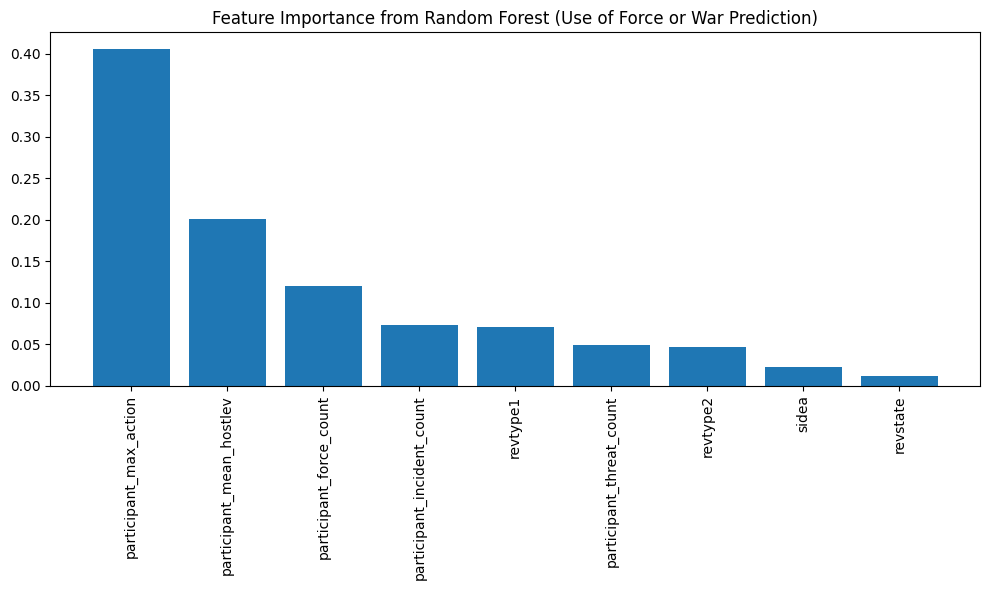

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv("final_participant_modeling_dataset_useforce.csv")


X = df.drop(columns=['dispnum', 'ccode', 'use_force_or_war'])



importances = rf.feature_importances_

sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices])
plt.xticks(range(len(importances)), X.columns[sorted_indices], rotation=90)
plt.title("Feature Importance from Random Forest (Use of Force or War Prediction)")
plt.tight_layout()
plt.savefig('feature_importance.jpg')
plt.show()
